In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

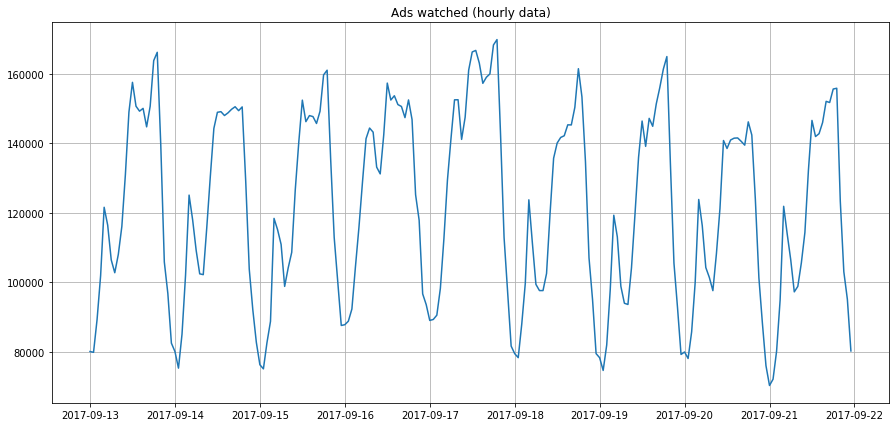

In [2]:
ads = pd.read_csv('Datasets/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('Datasets/currency.csv', index_col=['Time'], parse_dates=['Time'])
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

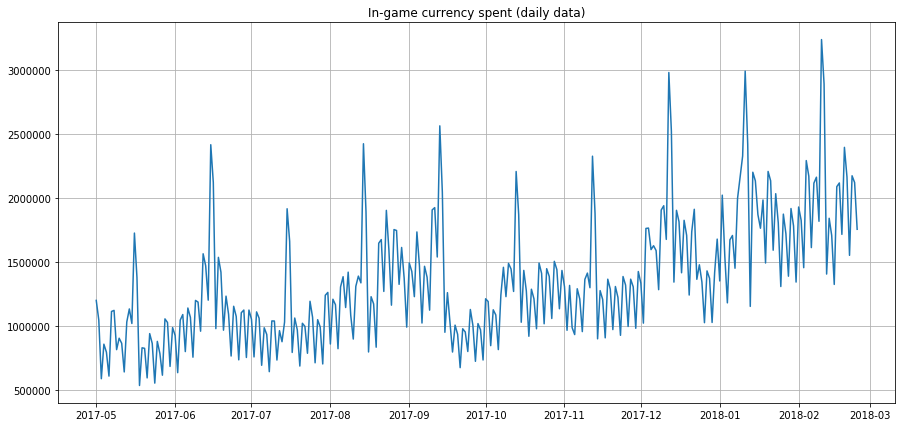

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [4]:

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])

moving_average(ads, 24) # prediction for the last observed day (past 24 hours)

116805.0

In [6]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)


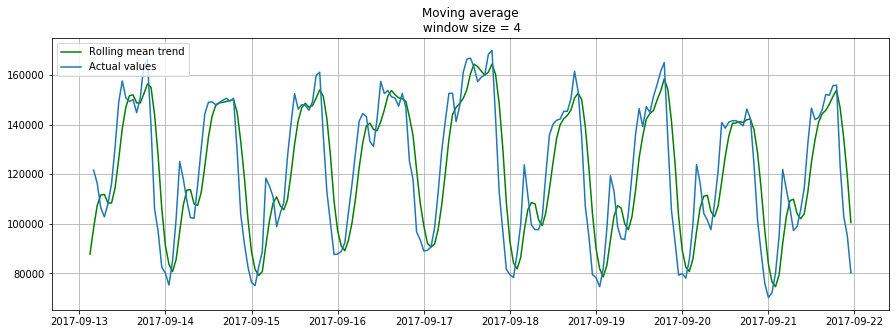

In [7]:
plotMovingAverage(ads, 4) 

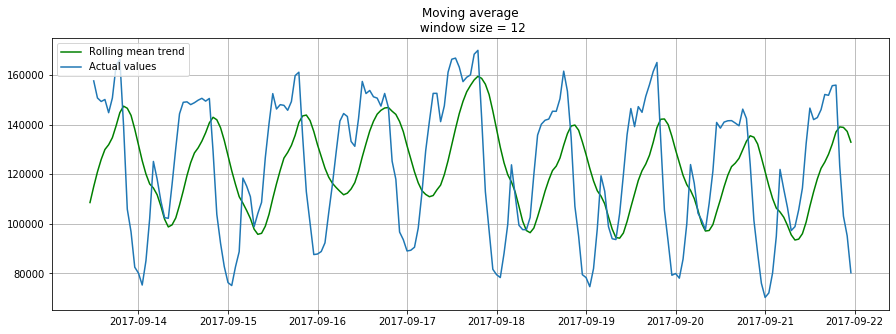

In [8]:
plotMovingAverage(ads, 12) 

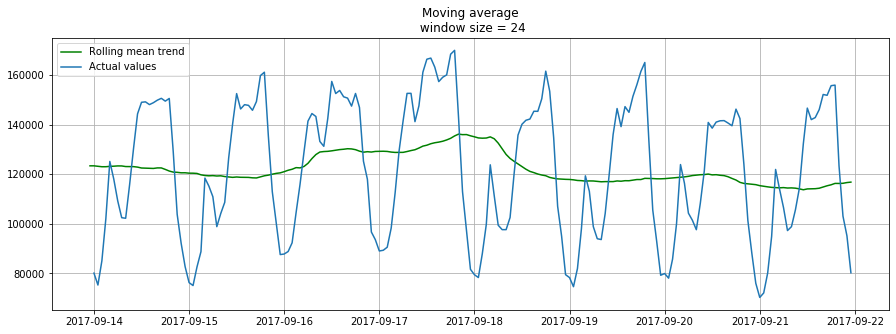

In [9]:
plotMovingAverage(ads, 24)

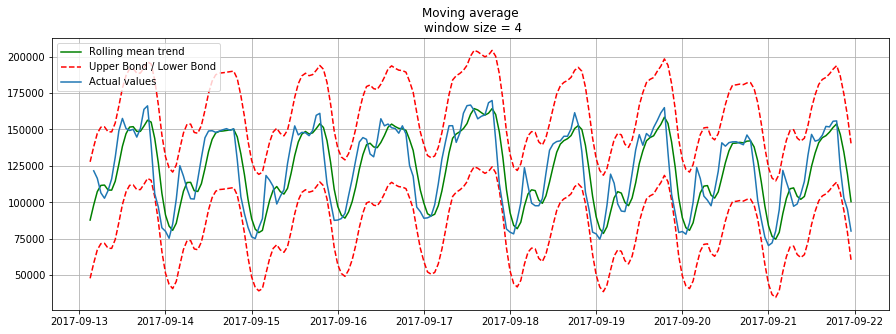

In [10]:
plotMovingAverage(ads, 4, plot_intervals=True)

In [11]:
ads_anomaly = ads.copy()
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 # say we have 80% drop of ads 

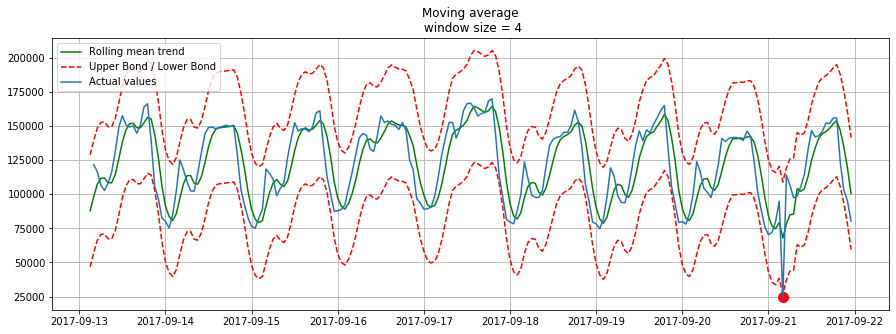

In [12]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

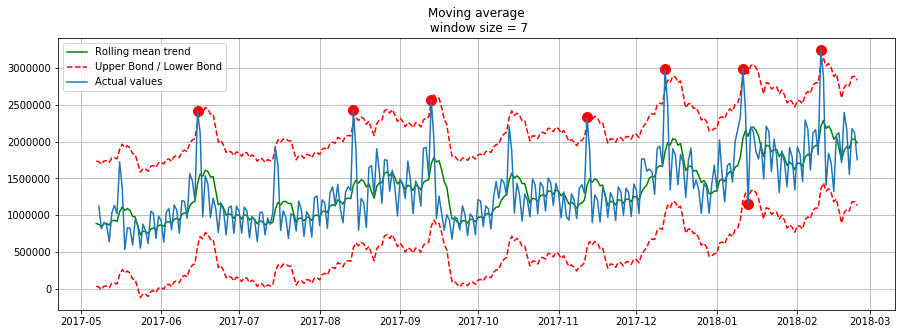

In [13]:
plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) # weekly smoothing


In [30]:
def weighted_average(series, weights):
    """
        Calculate weighter average on series
    """
    result = 0.0
#    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
weighted_average(ads, [0.6, 0.3, 0.1]) #(t-3 gets 0.6, t-2 gets 0.3 and t-1 gets 0.1) not anymore

87025.5

In [31]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

dataset = pd.read_csv('Datasets/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

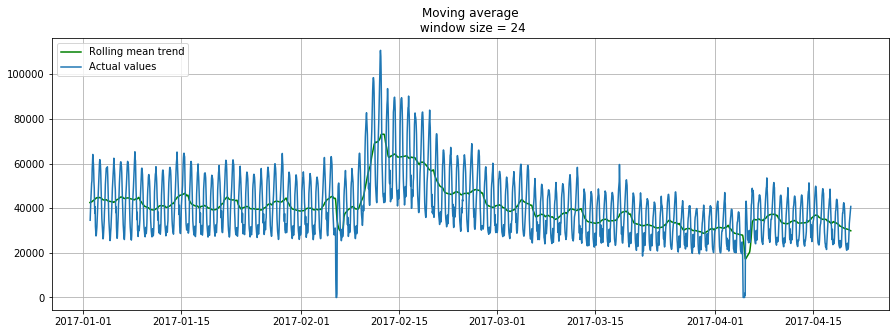

In [32]:
plotMovingAverage(dataset, 24) # сглаживаем по дням


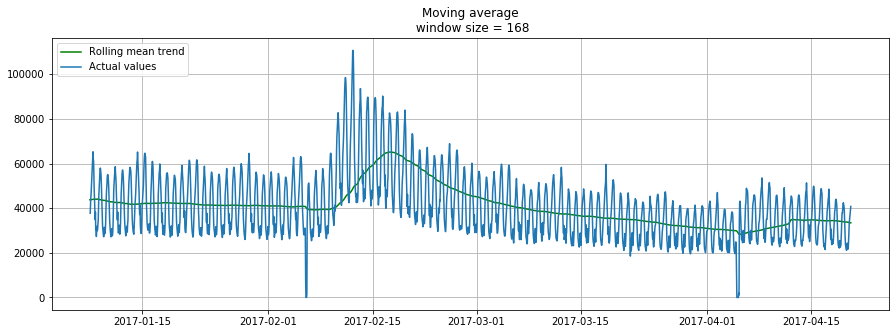

In [33]:
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям

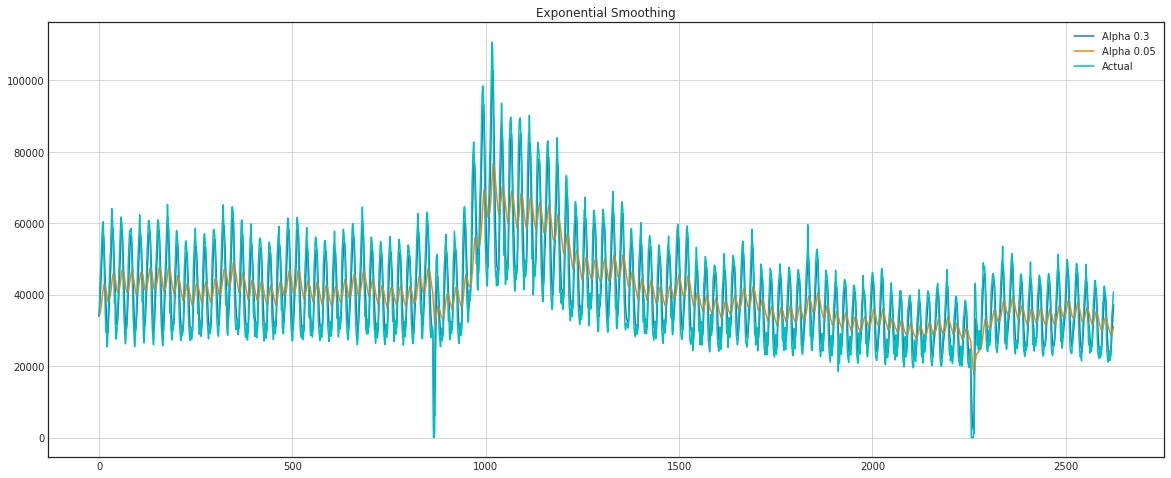

In [34]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Users, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Users.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

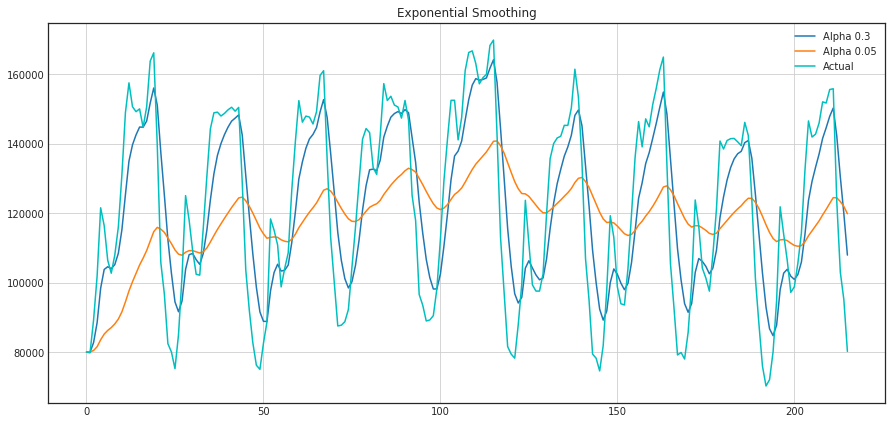

In [35]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])

In [36]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

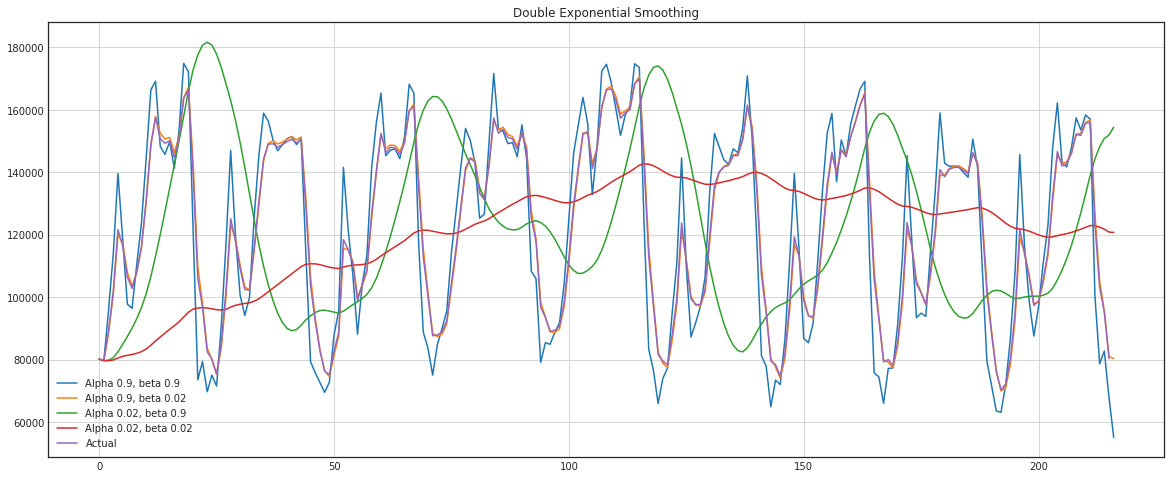

In [37]:
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])


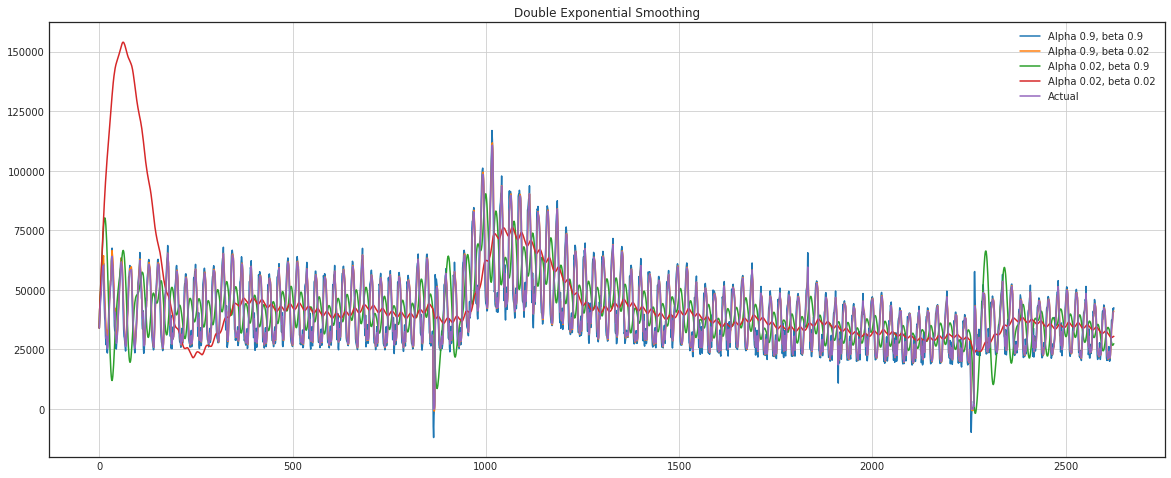

In [38]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)


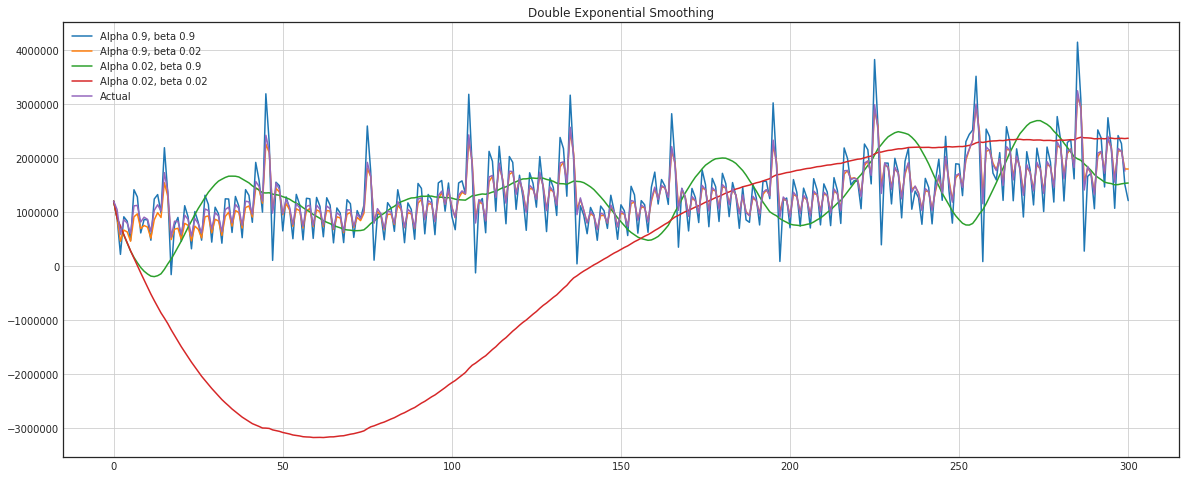

In [39]:
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])
